# Importações

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

# Não Supervisionado

# Lendo dataset

In [2]:
pokemon_df = pd.read_csv("../../Datasets/Pokemon.csv")

In [3]:
pokemon_df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

Dataset com dados de pokemons até a sexta geração
Com as colunas de:
- **\#** : Número do pokemon
- **Name** : Nome do pokemon
- **Type 1** : Tipo 1 do pokemon
- **Type 2** : Tipo 2 do pokemon
- **Total** : Soma total dos atributos do pokemon.
- **HP** : Vida do pokemon.
- **Attack** : Ataque do pokemon
- **Defense** : Defesa do pokemon
- **Sp. Atk** : Ataque especial do pokemon
- **Sp. Def** : Defesa especial do pokemon
- **Speed** : Velocidade do pokemon
- **Generation** : Geração do pokemon
- **Legendary** : Se o pokemon é lendário ou não

Aqui checamos se realmente só temos 6 gerações

In [4]:
pokemon_df['Generation'].min()

1

In [5]:
pokemon_df['Generation'].max()

6

Aqui damos uma olhada no dataset para ver como os dados estão

In [6]:
pokemon_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# KMeans

## Função que roda o kmeans em um dataset X calculando k medias

In [7]:
def calculateKMeans(dataset,n_clusters):
    model = KMeans(n_clusters=n_clusters,random_state=15)
    model.fit(dataset)
    return model    

## Checando quantidade de nulos no dataset

In [8]:
pokemon_df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

# Pegando colunas para treino e normalizando

Foram escolhidas algumas colunas para serem usadas para treinar
poderiam ter sido usadas todas, no entato, as colunas que não são
numéricas precisariam ser tratadas.

Nesse exemplo foram selecionadas apenas colunas numéricas
e foi aplicada uma normalização utilizando o StandardScaler,
isso é feito devido a média ser muito sensível a valores muito
altos, então a normalização ajuda a blindar alguns problemas da média.

In [9]:
columns_train = ['HP', 'Attack', 'Defense', 'Speed', 'Sp. Atk', 'Sp. Def']
scaler = StandardScaler()
pokemon_scaled_df = scaler.fit_transform(pokemon_df[columns_train])

Executando o Kmeans com 6 clusters, pois temos 6 gerações de pokemon

In [10]:
modelo = calculateKMeans(pokemon_scaled_df,6)

## Pegando todas as classificações feitas pelo modelo e colocando no dataframe original

In [11]:
pokemon_df['Cluster'] = modelo.labels_

In [12]:
pokemon_df['Cluster']

0      1
1      3
2      4
3      2
4      1
      ..
795    4
796    2
797    2
798    2
799    2
Name: Cluster, Length: 800, dtype: int32

In [13]:
pokemon_df['Generation'].value_counts()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64

In [14]:
pokemon_df['Cluster'].value_counts()

1    283
3    173
2    113
0     79
5     78
4     74
Name: Cluster, dtype: int64

# Checando distribuição dos clusters por atributos

In [15]:
columns_analyze_1 = ['Attack', 'Defense','Sp. Atk', 'Sp. Def','Generation','Cluster']

In [16]:
columns_analyze_2 = ['Total', 'HP',  'Speed', 'Generation', 'Cluster']

In [17]:
columns_analyze_3 = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Cluster']

In [18]:
print(np.__version__)
print(sns.__version__)

1.23.5
0.12.2


# Analisando distribuição dos clusters considerando algumas colunas

## ['Attack', 'Defense','Sp. Atk', 'Sp. Def','Generation','Cluster']

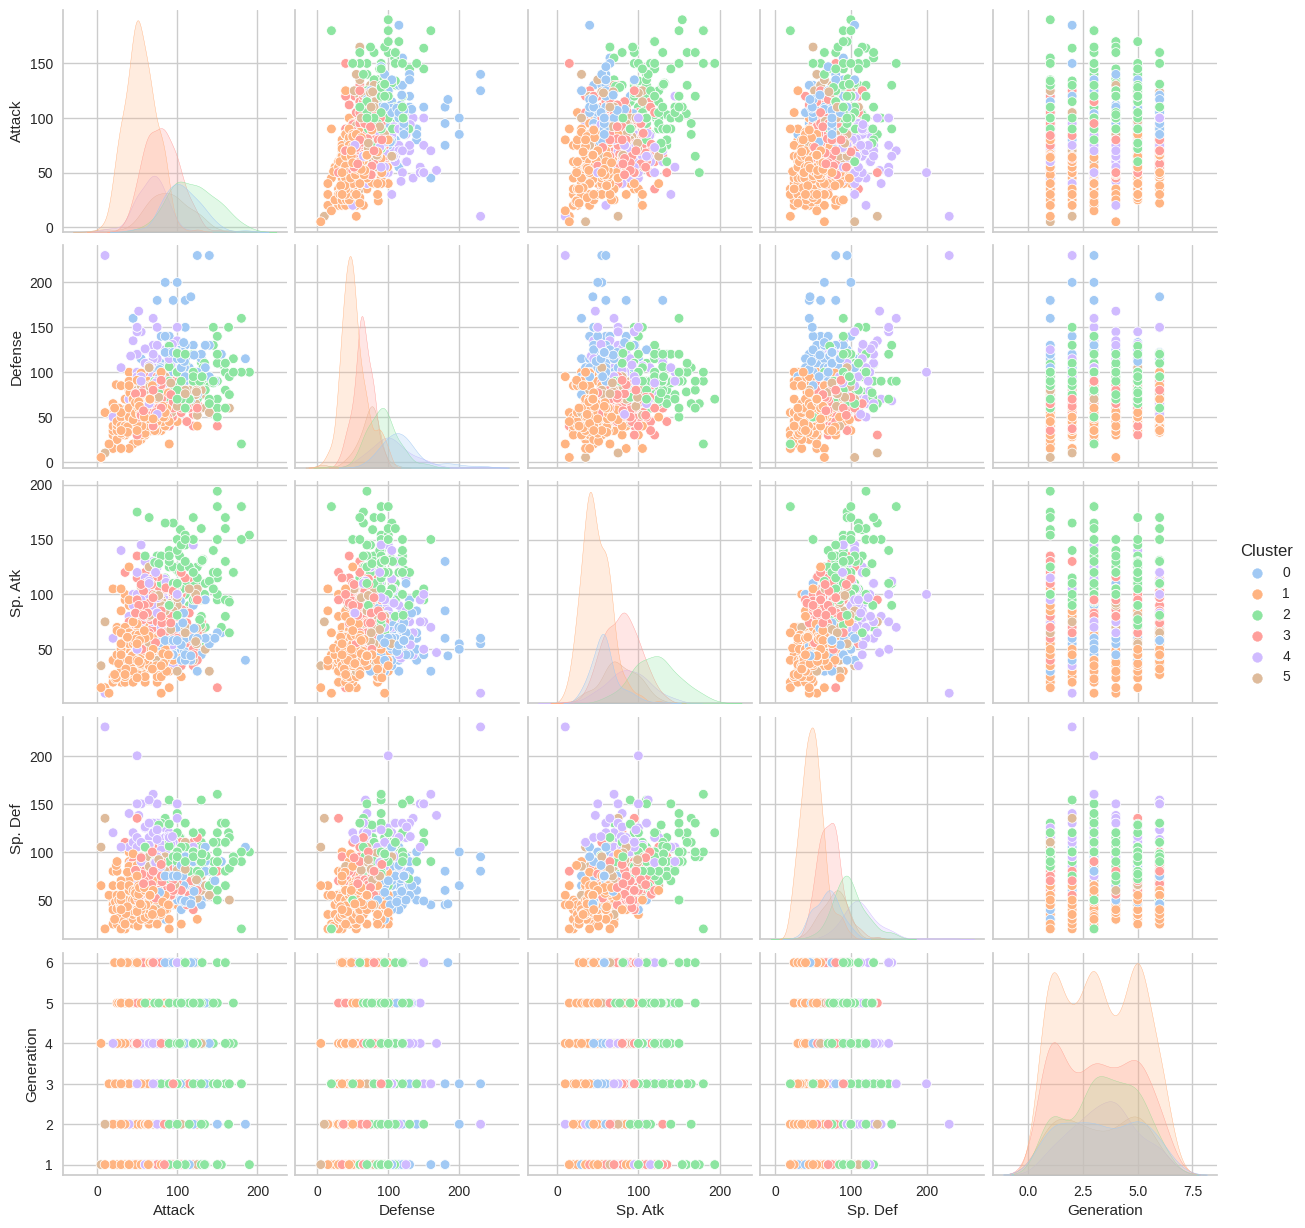

In [19]:
sns.pairplot(pokemon_df[columns_analyze_1], hue = "Cluster",palette='pastel')
plt.show()

## ['Total', 'HP',  'Speed', 'Generation', 'Cluster']

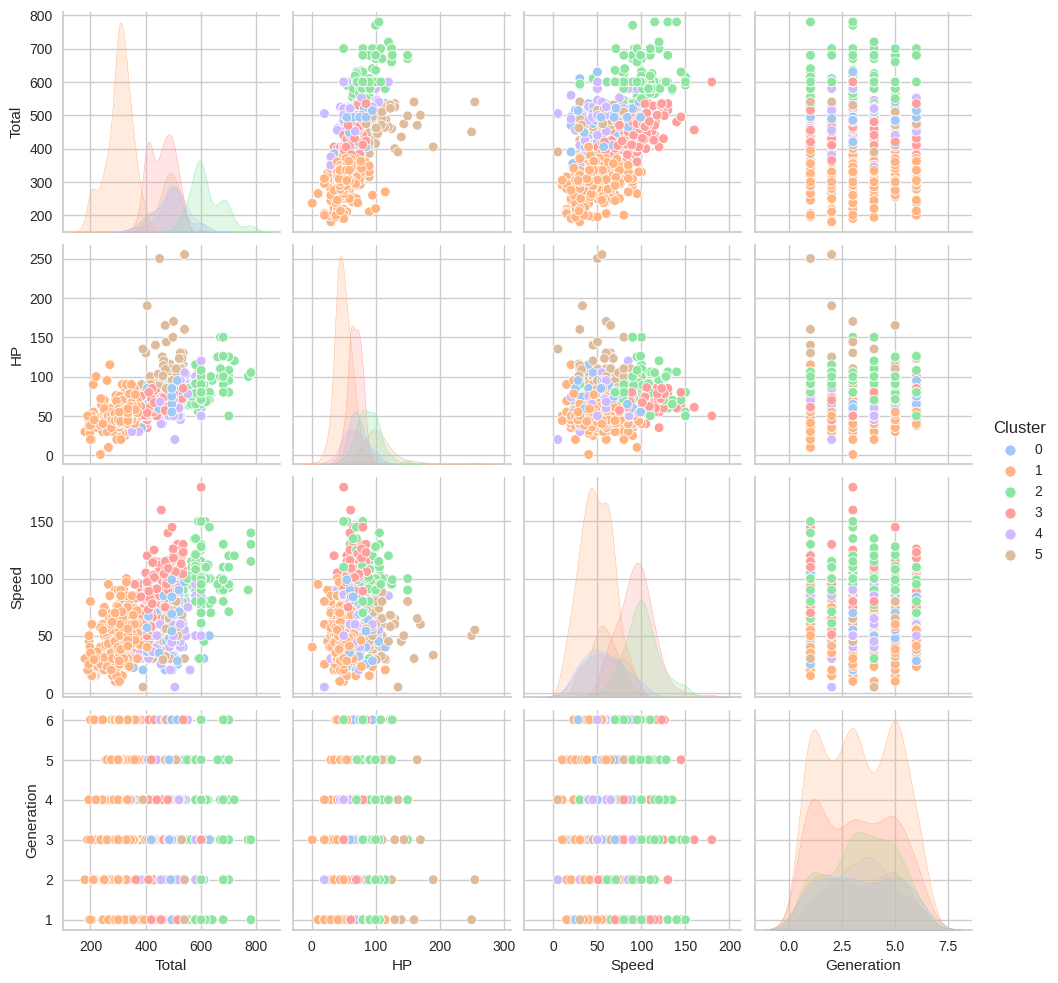

In [20]:
sns.pairplot(pokemon_df[columns_analyze_2], hue = "Cluster",palette='pastel')
plt.show()

## ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Cluster']

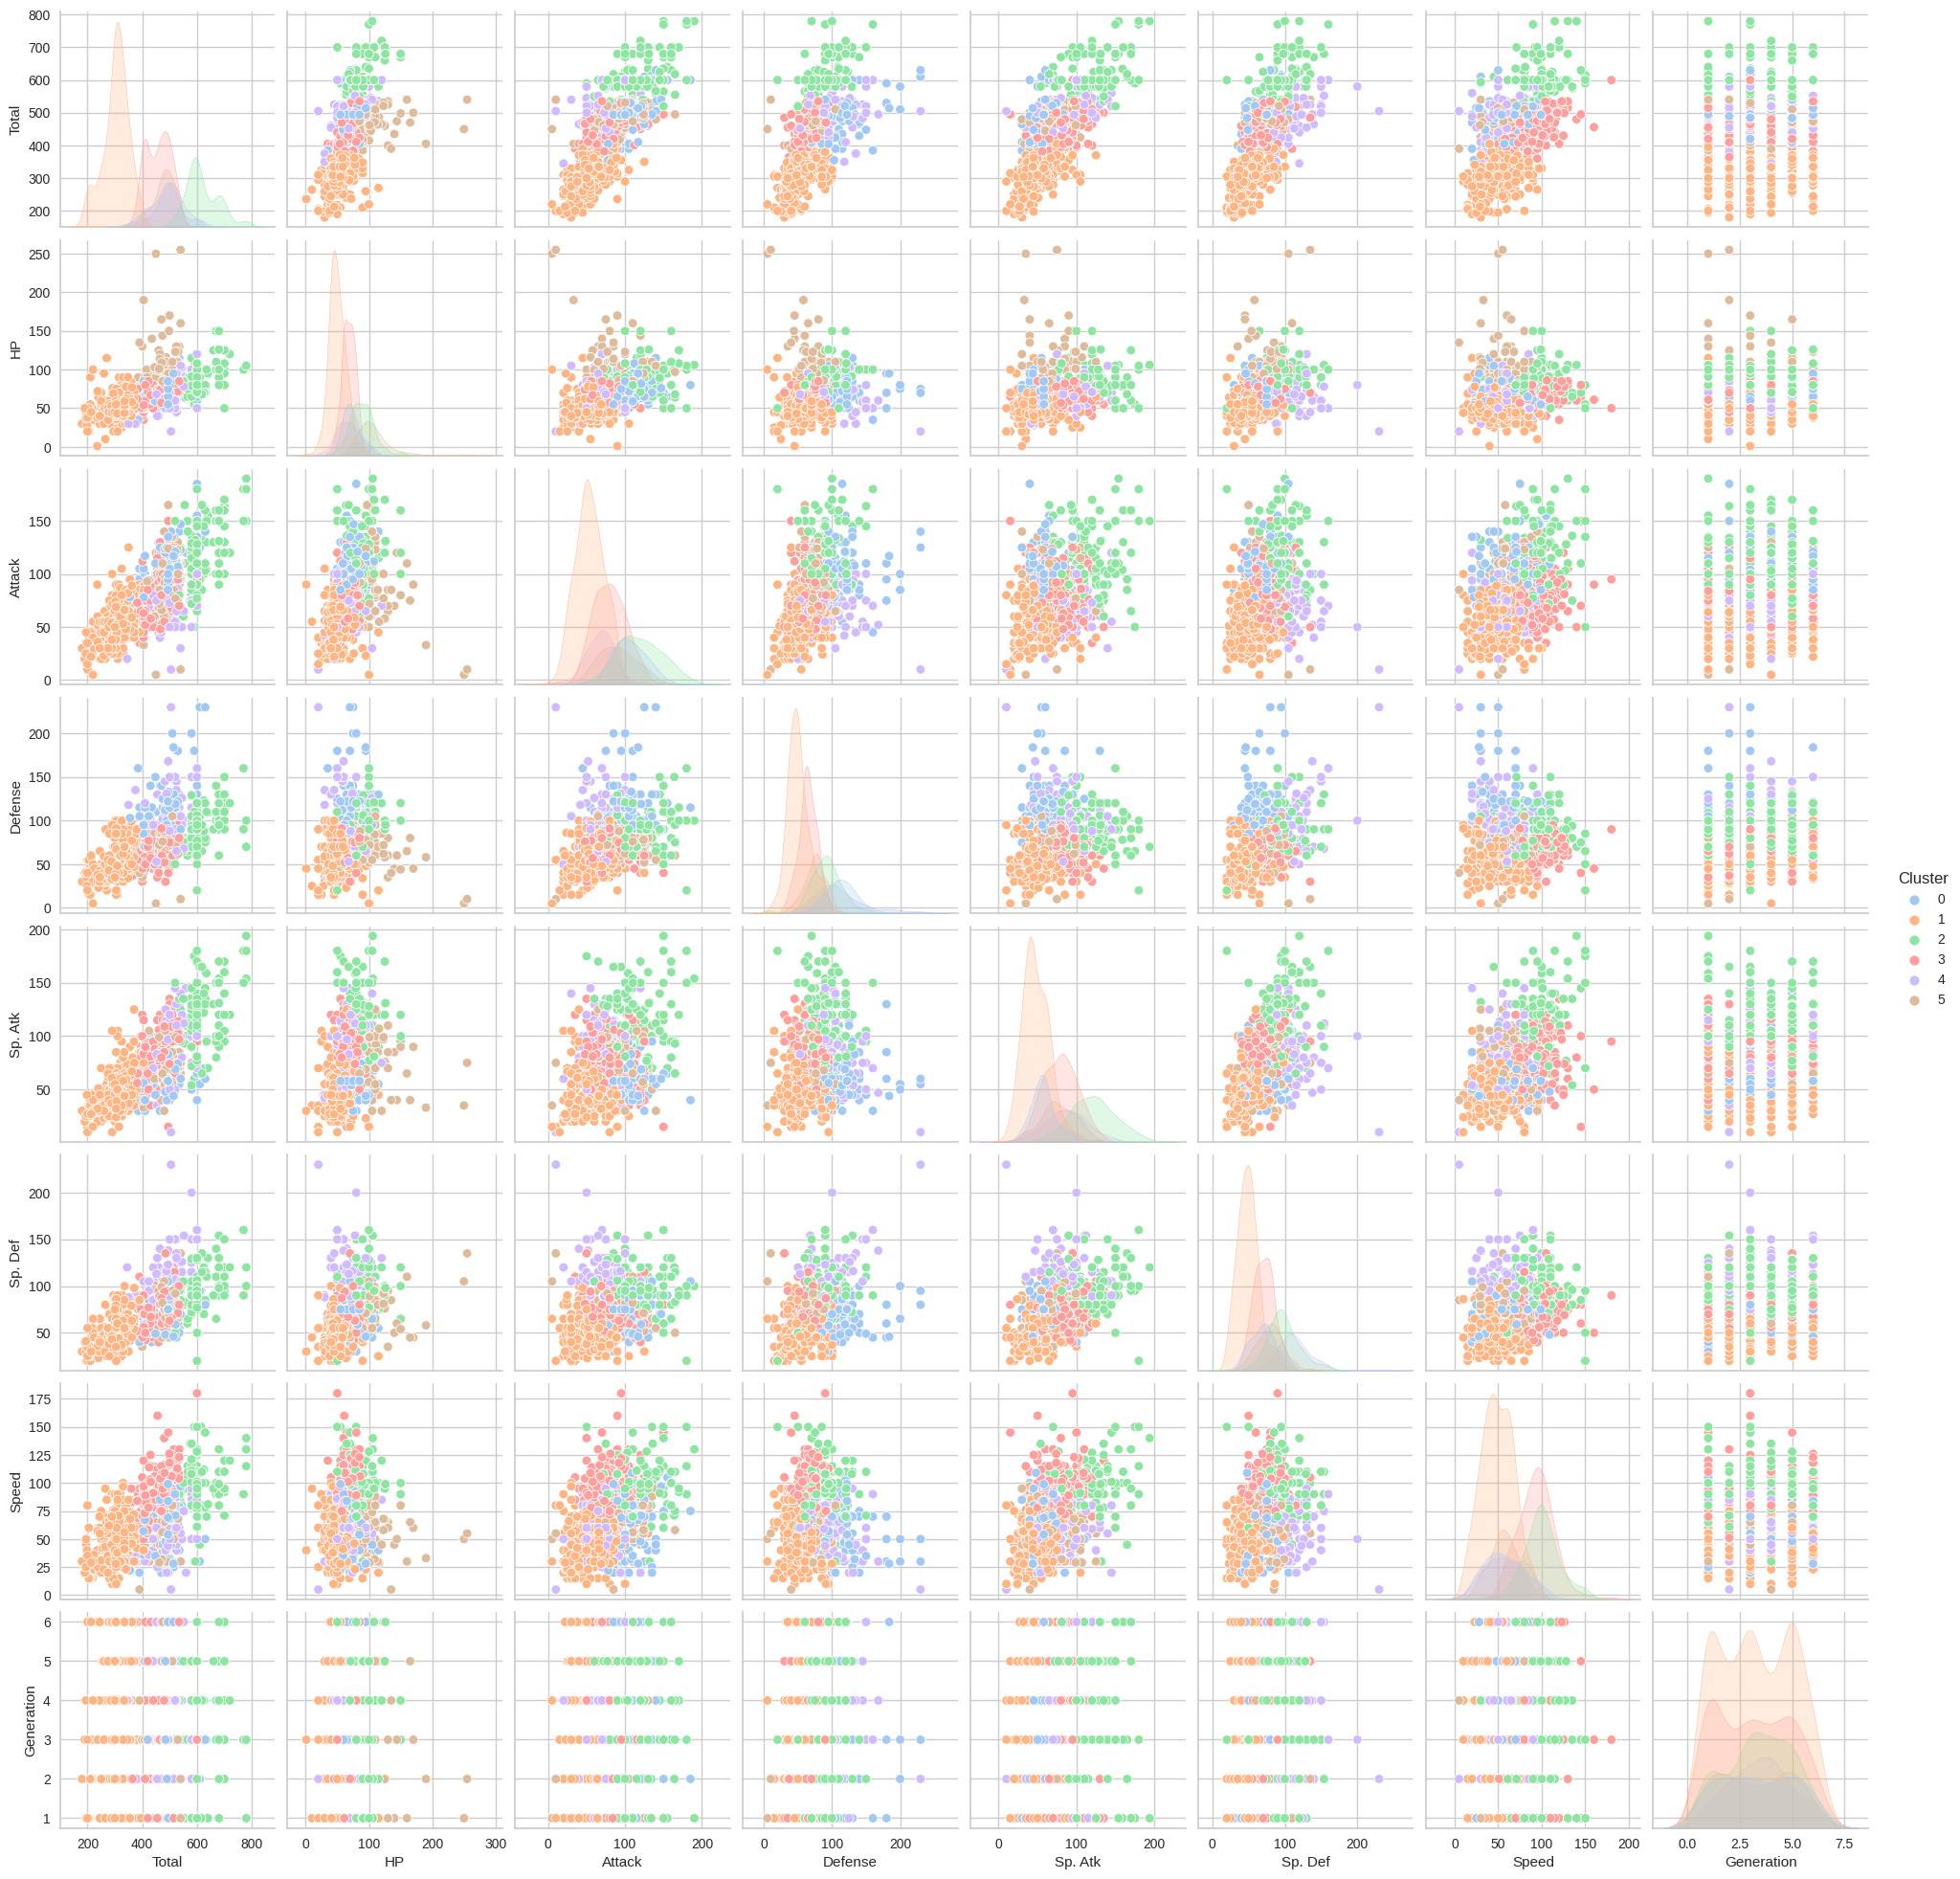

In [21]:
sns.pairplot(pokemon_df[columns_analyze_3], hue = "Cluster",palette='pastel')
plt.show()

# Calculando quantidade de clusters

- Inicialmente a quantidade de clusters é limitada a raiz quadrada do número de amostras.
- Depois calculamos a quantidade de clusters ideal usando o método do cotovelo
- Depois calculamos a quantidade ideal de clusters usando o método da silhueta numérico e visual

In [22]:
limit = int((pokemon_df.shape[0]//2)**0.5)
limit

20

## Cotovelo

Com o método do cotovelo avaliamos no gráfico onde a melhora nos níveis de variação começa a cair mais devagar.
Como o KMeans calcula a distância das observações até o centro do agrupamento que ela pertence, o ideal é que essa distância seja a menor viável. Matematicamente falando, nós estamos buscando uma quantidade de agrupamentos em que a soma dos quadrados intra-clusters (do inglês, within-clusters sum-of-squares (wcss)) seja a menor possível, sendo zero o resultado ótimo.

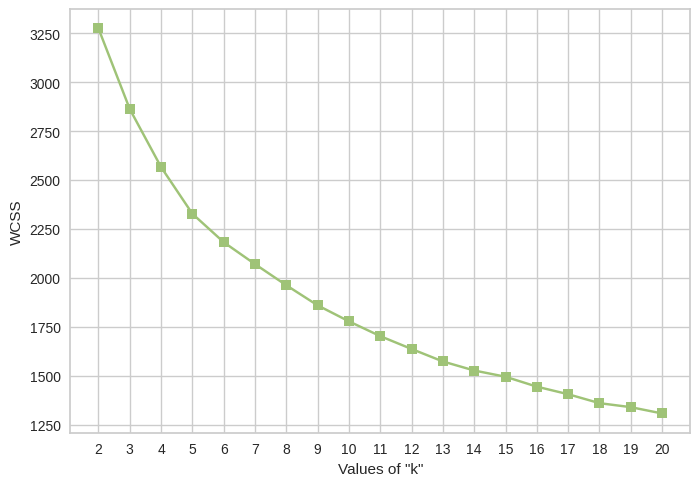

In [23]:
wcss = {}
  
for k in range(2,limit+1):
    model = calculateKMeans(pokemon_scaled_df,k)
    wcss[k] = model.inertia_
      
# plottando os valores de wcss para encontrar o valor de elbow
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xticks(np.arange(min(wcss.keys()), max(wcss.keys())+1, 1.0))
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

In [24]:
model =  KMeans(random_state=15)
visualizer = KElbowVisualizer(model, k=(2,limit))

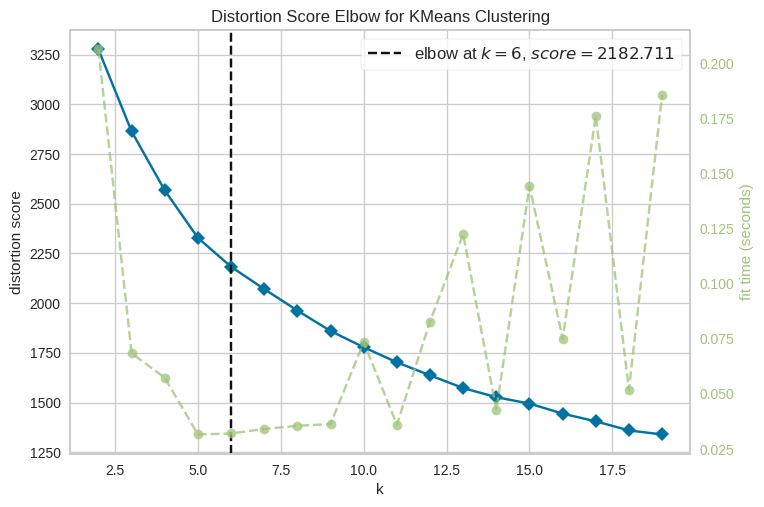

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
visualizer.fit(pokemon_scaled_df)
visualizer.show()

## Silhueta

Método de silhueta observando a média dos valores de silhueta, quanto maior a média dos valores de silhueta, melhor a distribuição

In [26]:
pokemon_scaled_df

array([[-0.95062622, -0.92490618, -0.79715364, -0.80150318, -0.2391303 ,
        -0.24818854],
       [-0.3628221 , -0.5241302 , -0.34791742, -0.28501525,  0.21955954,
         0.29115635],
       [ 0.42091674,  0.09244823,  0.29384863,  0.40363531,  0.83114599,
         1.01028289],
       ...,
       [ 0.42091674,  0.95565803, -0.44418232,  0.05931003,  2.36011211,
         2.08897269],
       [ 0.42091674,  2.49710411, -0.44418232,  0.40363531,  2.97169856,
         2.08897269],
       [ 0.42091674,  0.95565803,  1.4811158 ,  0.05931003,  1.74852566,
         0.65071962]])

In [27]:
for k in range(2, limit+1):
    model = calculateKMeans(pokemon_scaled_df,k)
    pred = model.predict(pokemon_scaled_df)
    score = silhouette_score(pokemon_scaled_df, pred)

    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

Silhouette Score for k = 2: 0.289
Silhouette Score for k = 3: 0.256
Silhouette Score for k = 4: 0.217
Silhouette Score for k = 5: 0.226
Silhouette Score for k = 6: 0.230
Silhouette Score for k = 7: 0.164
Silhouette Score for k = 8: 0.161
Silhouette Score for k = 9: 0.161
Silhouette Score for k = 10: 0.161
Silhouette Score for k = 11: 0.160
Silhouette Score for k = 12: 0.161
Silhouette Score for k = 13: 0.158
Silhouette Score for k = 14: 0.159
Silhouette Score for k = 15: 0.158
Silhouette Score for k = 16: 0.159
Silhouette Score for k = 17: 0.154
Silhouette Score for k = 18: 0.162
Silhouette Score for k = 19: 0.161
Silhouette Score for k = 20: 0.162


Método de silhueta observando todos os valores graficamente

Para observar graficamente olhamos o tamanho de cada cluster, considerando se estão com quantidades uniformes ou não, se os clusters possuem scores acima da média(linha tracejada vermelha ou não) e como está a distribuição dos valores (valores mais positivos são melhores )

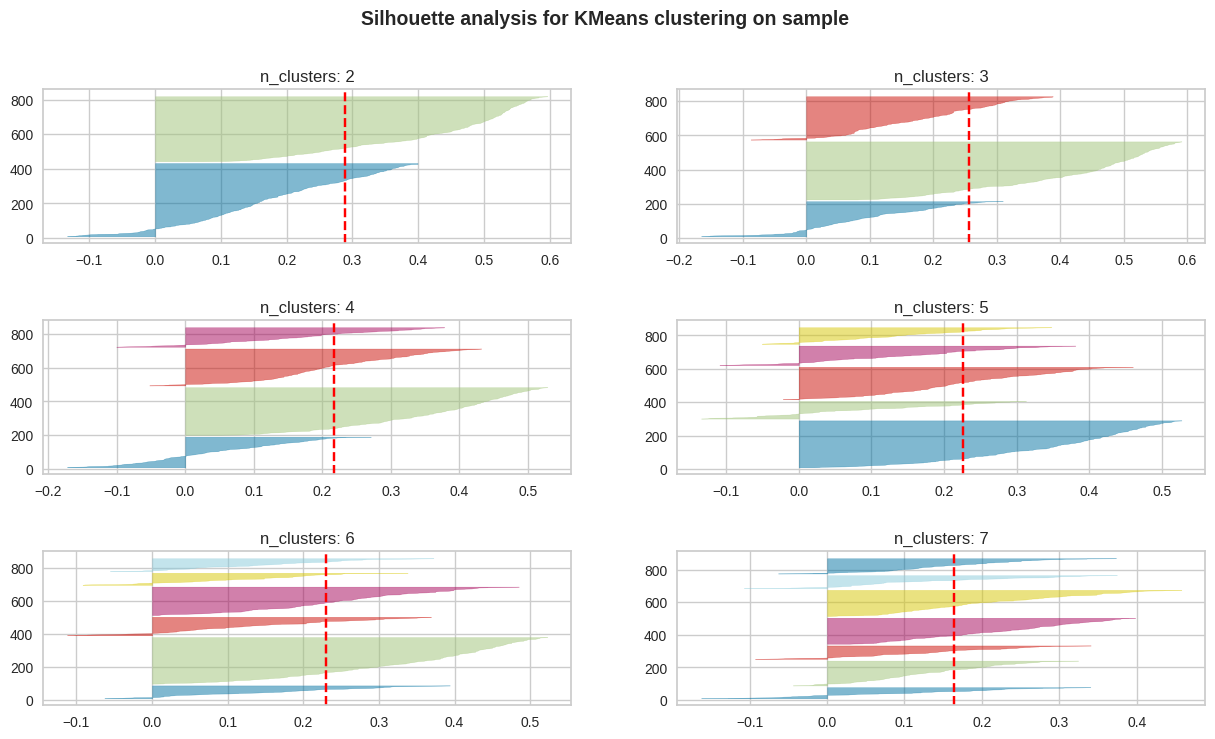

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
count = 2
for axes in ax:
    for axe in axes:
        axe.set_title(f"n_clusters: {count}")
        count+= 1
    
    
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Cria a instância KMeans para diferentes números de clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=15)
    q, mod = divmod(i, 2)
    #print('q:' +str(q))
    #print('mod:' +str(mod))
    
    '''
    Cria a instância SilhouetteVisualizer com a instância KMeans e dá um fit no visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pokemon_scaled_df)
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample",
        fontsize=14,
        fontweight="bold",
    )

Com a silhueta e cotovelo podemos ver que o número de clusters ideal para esse problema é 6, visto que os clusters possuem tamanhos mais uniformes, valores acima da média e não possuem muitos valores negativos.

Como a quantidade ideal de clusters é a quantidade de clusters que haviamos escolhido inicialmente não há necessidade de gerar as visualizações novamente

In [29]:
modelo

KMeans(n_clusters=6, random_state=15)

In [30]:
pokemon_df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Cluster'],
      dtype='object')

In [31]:
pokemon_df[['HP', 'Attack', 'Defense', 'Speed', 'Sp. Atk', 'Sp. Def']].corr()

,HP,Attack,Defense,Speed,Sp. Atk,Sp. Def
HP,1.000000,0.422386,0.239622,0.175952,0.362380,0.378718
Attack,0.422386,1.000000,0.438687,0.381240,0.396362,0.263990
Defense,0.239622,0.438687,1.000000,0.015227,0.223549,0.510747
Speed,0.175952,0.381240,0.015227,1.000000,0.473018,0.259133
Sp. Atk,0.362380,0.396362,0.223549,0.473018,1.000000,0.506121
Sp. Def,0.378718,0.263990,0.510747,0.259133,0.506121,1.000000


In [32]:
'HP', 'Attack', 'Defense', 'Speed', 'Sp. Atk', 'Sp. Def'

('HP', 'Attack', 'Defense', 'Speed', 'Sp. Atk', 'Sp. Def')

In [33]:
predictions = modelo.predict(pokemon_scaled_df)

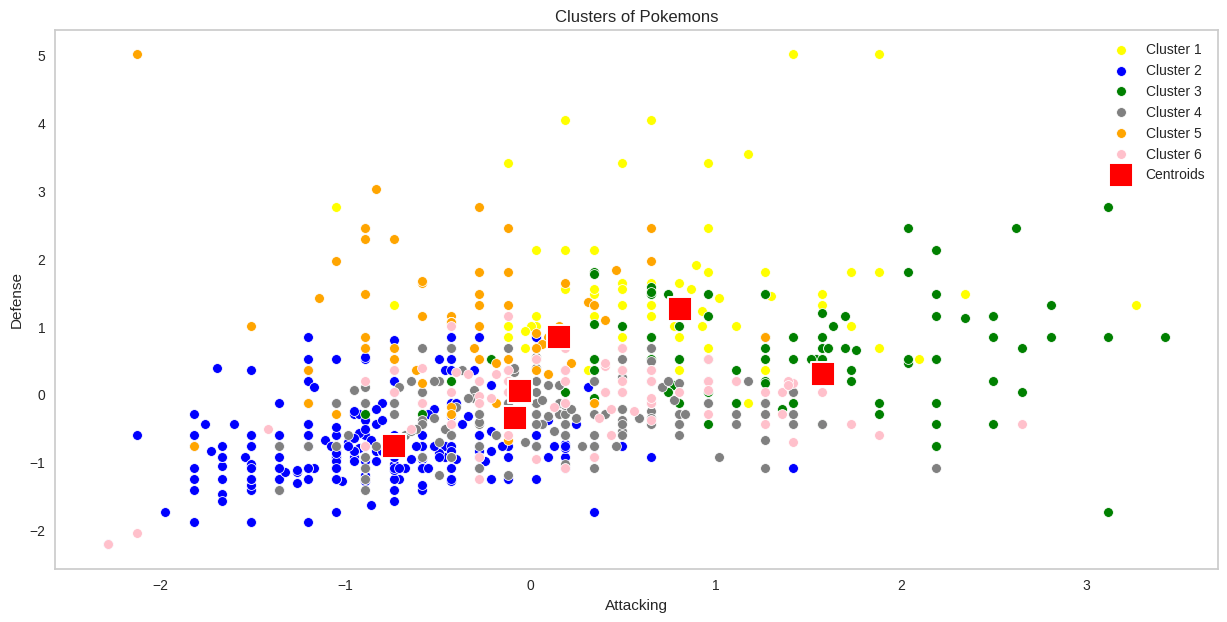

In [38]:
# Visualising the clusters
plt.figure(figsize=(15,7))
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 0, 1], \
                y=pokemon_scaled_df[predictions == 0, 2], \
                color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 1, 1], \
                y=pokemon_scaled_df[predictions == 1, 2], \
                color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 2, 1], \
                y=pokemon_scaled_df[predictions == 2, 2], \
                color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 3, 1], \
                y=pokemon_scaled_df[predictions == 3, 2], \
                color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 4, 1], \
                y=pokemon_scaled_df[predictions == 4, 2], \
                color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(None, \
                x=pokemon_scaled_df[predictions == 5, 1], \
                y=pokemon_scaled_df[predictions == 5, 2], \
                color = 'pink', label = 'Cluster 6',s=50)
sns.scatterplot(None, \
                x=modelo.cluster_centers_[:, 0], 
                y=modelo.cluster_centers_[:, 1], \
                color = 'red', label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('Clusters of Pokemons')
plt.xlabel('Attacking')
plt.ylabel('Defense')
plt.legend()
plt.show()
